Load Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Load Data

In [41]:
df = pd.read_excel("/Users/madisonwozniak/Desktop/STAT486/final_project/original_data/food_affordability.xls", sheet_name="Food_afford_cdp_co_region_ca")
df = df.drop(df.index[-1]) # remove last row because it is not part of the data

# Feature Engineering

In [42]:
# make factors 
df['region_code'] = df['region_code'].astype('category')
df['race_eth_code'] = df['race_eth_code'].astype('category')
df['geotypevalue'] = df['geotypevalue'].astype('category')
df['county_fips'] = df['county_fips'].astype('category')

Create features with zip code and lat/lon

In [43]:
all_zipcodes = pd.read_csv('zip_code_database.csv')

# names of all counties in the dataset
counties = ['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa',
       'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn',
       'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen',
       'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino',
       'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange',
       'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma',
       'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne',
       'Ventura', 'Yolo', 'Yuba']

# match my counties with those in the zipcode database
city_zipcodes = all_zipcodes[all_zipcodes['primary_city'].isin(counties)]
features_to_join = city_zipcodes[['latitude', 'longitude', 'primary_city']]
features_to_join['county_name'] = features_to_join['primary_city']
features_to_join = features_to_join.drop('primary_city', axis = 1)

# merge datasets
df = pd.merge(df, features_to_join, on = 'county_name', how = 'outer')

/var/folders/8f/l9_yqvn54_ldh6kclbdcgvfh0000gn/T/ipykernel_49542/73613974.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_to_join['county_name'] = features_to_join['primary_city']


In [44]:
# get all the numeric/categorical features together 
numeric_predictors = df.select_dtypes(include=['number']).drop('affordability_ratio', axis = 1) # df
numeric_predictors = numeric_predictors.drop(numeric_predictors.filter(regex='^is').columns, axis=1)
numeric_predictors = numeric_predictors.drop(columns = 'CA_RR_Affordability')
num_pred_names = numeric_predictors.columns

categorical_predictors = df.select_dtypes(include=['object', 'category']) # df
dummy_vars = df.filter(regex='^is')  # assuming dummy variables start with "is"
categorical_predictors = pd.concat([categorical_predictors, dummy_vars], axis=1)
cat_pred_names = categorical_predictors.columns

# consistent types for numeric columns
df[num_pred_names] = df[num_pred_names].apply(pd.to_numeric, errors='coerce')
# consistent types for categorical columns
df[cat_pred_names] = df[cat_pred_names].astype(str)

household-level affordability

In [45]:
df['affordability_per_person'] = df['affordability_ratio'] / df['ave_fam_size']

Final dataframe to csv

In [46]:
df.to_csv('final_data.csv', index = False)

# Supervised Machine Learning Models

In [53]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

### Data Preparation

In [48]:
df['median_income'] = df['median_income'].fillna(df['median_income'].mean()) # make sure response has no NAs

# get my X and Y matrices
X = df.drop(columns = ['median_income', 'version', 'ind_id', 'ind_definition', 'reportyear'])
y = df['median_income']

In [49]:
# extract only the column names for each type
numeric_features = X.select_dtypes(include = ['number']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=307) # split the data

# make transformers for each data type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler())                  
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('filtering', SelectPercentile(f_regression, percentile=50))     
])

# run both through the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),      
        ('cat', categorical_transformer, categorical_features)  
    ])

In [51]:
# may need to use samples for testing out some models
X_train_sample = X_train.sample(n=50000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# scaling response - do this to full train/test when I am done with the samples
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train_sample.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# taking the log of income may make most sense
y_train_log = np.log1p(y_train_sample)
y_test_log = np.log1p(y_test)


In [52]:
# looking at how my predictors are correlated with the response 
numeric_X_train = X_train_sample.select_dtypes(include=['number'])
corr = numeric_X_train.corrwith(y_train_log)
print(corr.sort_values(ascending=False))

food_afford_decile          0.881916
longitude                   0.003219
latitude                   -0.051667
cost_yr                    -0.053089
ave_fam_size               -0.083369
rse_food_afford            -0.241342
se_food_afford             -0.282512
LL95_affordability_ratio   -0.325106
UL95_affordability_ratio   -0.327396
affordability_ratio        -0.789804
CA_RR_Affordability        -0.789804
affordability_per_person   -0.798263
dtype: float64


### KNeighbors Regressor

In [14]:
# sample KNN Regressor
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=5, weights='distance'))  
])
pipe.fit(X_train_sample, y_train_log)
y_test_pred = pipe.predict(X_test)
test_mse = root_mean_squared_error(y_test_log, y_test_pred)
print(test_mse) #0.020348175708673553

0.0015055189271422165


### Linear Regression

In [56]:
# sample Linear Regression - log
lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  
])
lr_pipe.fit(X_train_sample, y_train_log)
y_test_pred = lr_pipe.predict(X_test)
test_mse = root_mean_squared_error(y_test_log, y_test_pred)
print(test_mse) # 0.06189138986827383


0.06189138986827383


Evaluate Model with Cross-Validation

In [57]:
scores = cross_val_score(lr_pipe, X_train_sample, y_train_log, scoring='neg_mean_squared_error', cv=5)
print(f"Average MSE: {-scores.mean()}")

Average MSE: 0.004029036845234136


Grid Search with Ridge

In [58]:
ridge_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength for Ridge
}
# GridSearchCV
grid_search = GridSearchCV(ridge_pipe, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_sample, y_train_log)
# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation MSE: {-grid_search.best_score_}")

Best Parameters: {'model__alpha': 1}
Best Cross-Validation MSE: 0.004154922630392588


Grid Search with Lasso

In [ ]:
lasso_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength for Lasso
}
# GridSearchCV
grid_search = GridSearchCV(lasso_pipe, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_sample, y_train_sample)
# Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation MSE: {-grid_search.best_score_}")

### Decision Trees/Random Forests

In [59]:
# make sure I don't have any nulls
X_train_sample.isnull().sum()
# since I do, I need to impute missing values

race_eth_code                   0
race_eth_name                   0
geotype                         0
geotypevalue                    0
geoname                         0
county_name                     0
county_fips                     0
region_name                     0
region_code                     0
cost_yr                      5114
affordability_ratio         32591
LL95_affordability_ratio    32997
UL95_affordability_ratio    32997
se_food_afford              32997
rse_food_afford             32997
food_afford_decile          45459
CA_RR_Affordability         32591
ave_fam_size                 2462
latitude                      616
longitude                     616
dtype: int64

In [61]:
# make new numeric transformer since I only want to impute now
dt_numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='mean'))
])
dt_preprocessor = ColumnTransformer(
    transformers=[
        ('num', dt_numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
pipe = Pipeline(steps=[
    ('preprocessor', dt_preprocessor),
    ('model', DecisionTreeRegressor(random_state = 42))  
])
pipe.fit(X_train_sample, y_train_sample) # do not use scaled versions because decision trees don't need that
y_test_pred = pipe.predict(X_test)
test_mse = root_mean_squared_error(y_test, y_test_pred)
print(test_mse)

343.3652199835445


Tuning Decision Tree with Grid Search

In [62]:
param_grid = {
    'model__max_depth': [3, 5, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_sample, y_train_sample)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best MSE: {-grid_search.best_score_}")

Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best MSE: 111916.4900619498


### Gradient Boosting XGBoost

In [65]:
# using XGBoost

# need to deal with categorical
X_train_processed = preprocessor.fit_transform(X_train_sample, y_train_sample)
X_test_processed = preprocessor.transform(X_test)

xgb_model = XGBRegressor(n_estimators=100, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         random_state=42,
                        )
xgb_model.fit(X_train_processed, y_train_sample)
# maybe add l1/l2 regularization 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Evaluate Model

In [66]:
y_test_pred = xgb_model.predict(X_test_processed)
mse = root_mean_squared_error(y_test, y_test_pred)
print(f'Test rMSE: {mse}')

Test rMSE: 860.1672543401273


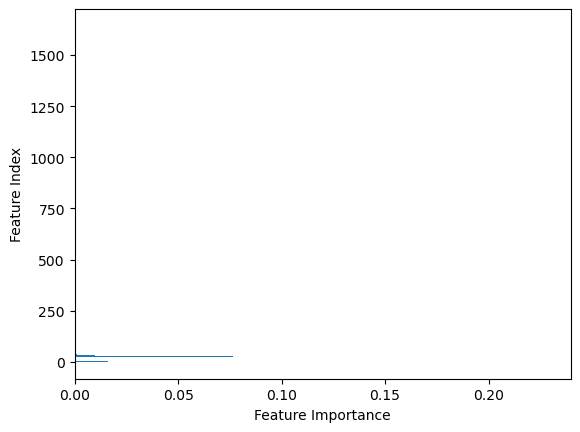

In [67]:
# graph feature importance
feature_importances = xgb_model.feature_importances_
plt.barh(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.show()

Grid Search for Hyperparam Tuning

In [68]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
gb_grid_search = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose = 1
)
gb_grid_search.fit(X_train_processed, y_train_sample)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best MSE: {-grid_search.best_score_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best MSE: 111916.4900619498


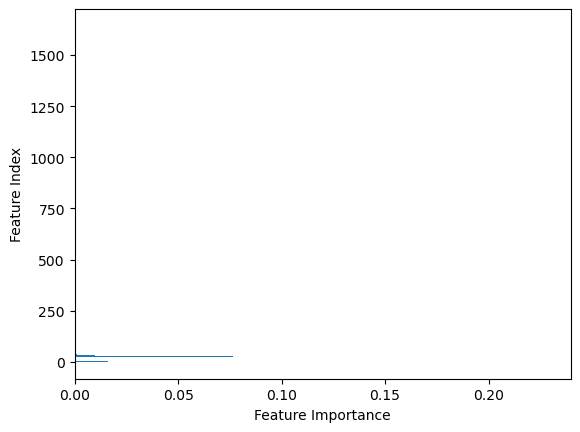

In [69]:
# graph feature importance
feature_importances = xgb_model.feature_importances_
plt.barh(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.show()

# Deep Learning Model with Hyperparam. Optimization

In [70]:
# load all DNN packages
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [72]:
# scale features 
scaler = StandardScaler(with_mean = False) # since some features are one hot encoded
X_train_DNN = scaler.fit_transform(X_train_processed)  # Preprocessed numeric/categorical data
X_test_DNN = scaler.transform(X_test_processed)

In [ ]:
# transform target

In [73]:
# define neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_DNN.shape[1],)),  # Input layer
    Dropout(0.2),  # Dropout for regularization
    Dense(64, activation='relu'),  # Hidden layer
    Dense(32, activation='relu'),  # Another hidden layer
    Dense(1)  # Output layer for regression
])

In [74]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [77]:
# train the model

# implement early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# convert sparse matrix to dense
X_train_DNN_dense = X_train_DNN.toarray()

history = model.fit(
    X_train_DNN_dense, y_train_sample,  # Use log-transformed targets if needed
    validation_split=0.2,  # Use part of the training data for validation
    epochs=20,  # Maximum number of epochs
    batch_size=32,  # Batch size for gradient updates
    callbacks=[early_stopping],  # Add early stopping
    verbose=1  # Print progress
)

Epoch 1/20
1250/1250 [==============================] - 6s 5ms/step - loss: 12159726.0000 - mae: 2319.2800 - val_loss: 11477338.0000 - val_mae: 1419.7272
Epoch 2/20
1250/1250 [==============================] - 2s 2ms/step - loss: 11395871.0000 - mae: 2257.4033 - val_loss: 10027022.0000 - val_mae: 1295.6523
Epoch 3/20
1250/1250 [==============================] - 2s 2ms/step - loss: 10779661.0000 - mae: 2206.1389 - val_loss: 9884460.0000 - val_mae: 1357.7731
Epoch 4/20
1250/1250 [==============================] - 3s 2ms/step - loss: 10079225.0000 - mae: 2118.9351 - val_loss: 10413955.0000 - val_mae: 1370.9906
Epoch 5/20
1250/1250 [==============================] - 2s 2ms/step - loss: 9802113.0000 - mae: 2091.2559 - val_loss: 8819658.0000 - val_mae: 1186.4773
Epoch 6/20
1250/1250 [==============================] - 3s 2ms/step - loss: 9008416.0000 - mae: 2028.6830 - val_loss: 10341945.0000 - val_mae: 1691.4844
Epoch 7/20
1250/1250 [==============================] - 2s 2ms/step - loss: 8602

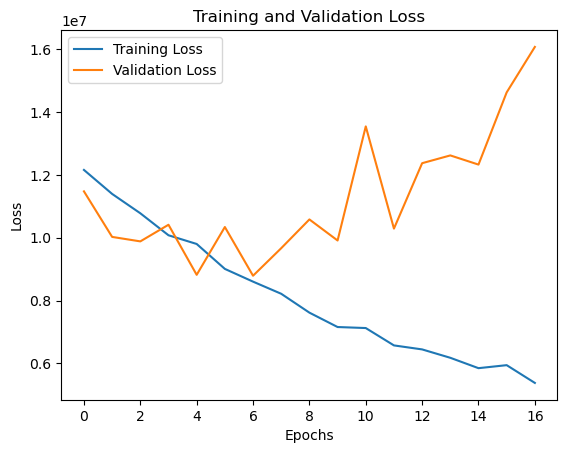

In [78]:
# plot training and validation loss to eval model performance

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [79]:
# evaluate model

# predict on test data
y_test_pred_dnn = model.predict(X_test_DNN)
rmse = root_mean_squared_error(y_test, y_test_pred_dnn)
print(f"Test rMSE: {mse}")

2308/2308 [==============================] - 4s 2ms/step
Test rMSE: 860.1672543401273


# Anomaly Detection or Cluster Analysis

Anomaly detection

identify data points significantly different from the rest (represent errors, unusualy events, important patterns)

can help identify income outliers
improve model performance
etc

Cluster Analysis

group similar data points based on characterisetics

reveal natural groupings or patterns

good for segmentation

In [98]:
# import libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [80]:
# anomaly detection on income with K Means

cluster = df[['median_income']]
# standardize income 
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster)

# fit K Means
kmeans = KMeans(n_clusters=3, random_state = 42)
df['income_cluster'] = kmeans.fit_predict(cluster_scaled)
# distances to centroid
distances = np.abs(cluster_scaled - kmeans.cluster_centers_[df['income_cluster']])
df['income_dist_centroid'] = distances

# set threshold
threshold = np.percentile(df['income_dist_centroid'], 99) # capture top 1% of anomalies

# label anomalies
df['is_anomaly'] = df['income_dist_centroid'] > threshold

# get anomalies
anomalies = df[df['is_anomaly']]

# visualize anomalies
plt.scatter(df.index, cluster_scaled, c=df['income_cluster'], cmap='viridis', label='Clusters')

plt.scatter(df[df['is_anomaly']].index, df[df['is_anomaly']]['median_income'], color='red', label='Anomalies', edgecolor='k')
plt.xlabel('Index')
plt.ylabel('Standardized Income')
plt.title('K-Means Clustering for Anomaly Detection')
plt.legend()
plt.show()

In [109]:
df.columns

Index(['ind_id', 'ind_definition', 'reportyear', 'race_eth_code',
       'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_name',
       'county_fips', 'region_name', 'region_code', 'cost_yr', 'median_income',
       'affordability_ratio', 'LL95_affordability_ratio',
       'UL95_affordability_ratio', 'se_food_afford', 'rse_food_afford',
       'food_afford_decile', 'CA_RR_Affordability', 'ave_fam_size', 'version',
       'latitude', 'longitude', 'affordability_per_person', 'income_cluster',
       'income_dist_centroid', 'is_anomaly'],
      dtype='object')

/var/folders/8f/l9_yqvn54_ldh6kclbdcgvfh0000gn/T/ipykernel_49542/1906728021.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_here['cluster'] = kmeans.fit_predict(X)


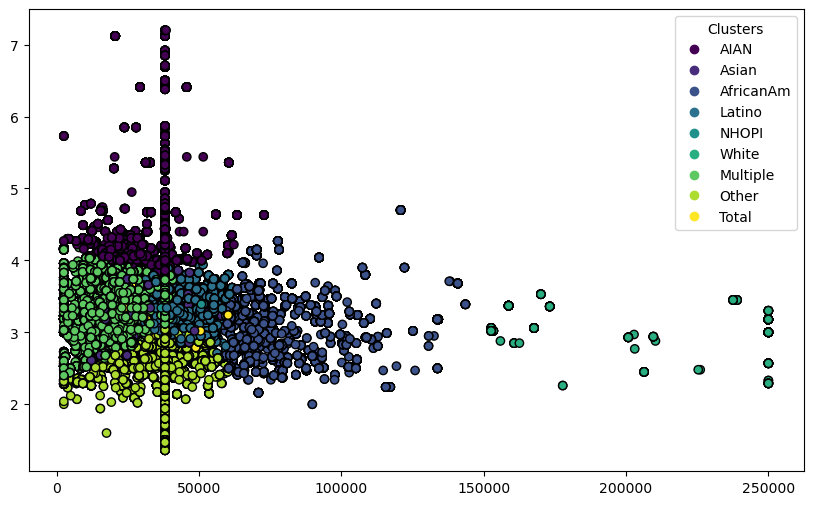

In [113]:
# anomaly detection on income, family size, race with K Means
features = df[['median_income','ave_fam_size', 'race_eth_name']]

df_here = df.dropna(subset=['median_income','ave_fam_size', 'race_eth_name'])  # Drop rows with missing values

# preprocess data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['median_income', 'ave_fam_size']),  # Scale numeric features
        ('cat', OneHotEncoder(), ['race_eth_name'])  # Encode categorical features
    ]
)

X = preprocessor.fit_transform(df_here)

# fit K Means
n_clusters = df['race_eth_name'].nunique()
kmeans = KMeans(n_clusters=n_clusters, random_state = 42)
df_here['cluster'] = kmeans.fit_predict(X)


plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_here['median_income'],
    df_here['ave_fam_size'],
    c=df_here['cluster'],  # Color by cluster
    cmap='viridis',
    edgecolor='k'
)

handles, _ = scatter.legend_elements()
legend_labels = df['race_eth_name'].unique()
plt.legend(handles, legend_labels, title="Clusters")

Some racial groups tend to cluster into lower-income categories

large family size doesn't seem to have a relationship with income level

In [ ]:
# Analyze centroids
print(kmeans.cluster_centers_)

silhouette = silhouette_score(X, df_here['cluster'])
print(f'Silhouette Score: {silhouette}')

# Dimension Reduction 

simplifying datasets with many features while keeping the most important info

# SHAP for Feature Importance